In [1]:
#Importamos librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Carga e inspección de control del Dataset1

In [2]:
df1 = pd.read_csv('/content/dataset1_editado.csv')
df1.head()

,produccion_gas_natural_cuenca_austral,produccion_gas_natural_cuenca_gsj,produccion_gas_natural_cuenca_neuquina,produccion_gas_natural_cuenca_noroeste,produccion_gas_natural_cuenca_cuyana,produccion_gas_natural_total,produccion_shale_gas,produccion_tight_gas,anio,produccion_no_convencional,produccion_convencional,mes
0,885167.3714,442014.6605,1.944920e+06,263495.3680,4599.6114,3.540197e+06,23465.959800,314046.25217,2014,337512.211970,3.202685e+06,1
1,793800.6656,403246.2098,1.756761e+06,233504.3885,4352.7275,3.191665e+06,22807.990191,284537.62290,2014,307345.613091,2.884319e+06,2
2,879715.0346,453502.3597,1.885451e+06,254380.6826,4891.7040,3.477941e+06,24844.175160,311893.06300,2014,336737.238160,3.141204e+06,3
3,740749.0121,438266.3703,1.833150e+06,239112.5697,4763.2185,3.256041e+06,30990.912010,313487.91707,2014,344478.829080,2.911563e+06,4
4,880061.9141,445484.1645,1.966218e+06,247344.8389,4877.9888,3.543987e+06,39014.194660,357115.97376,2014,396130.168420,3.147856e+06,5


In [3]:
df1.shape

(132, 12)

In [4]:
print(df1.columns)

Index(['produccion_gas_natural_cuenca_austral',
       'produccion_gas_natural_cuenca_gsj',
       'produccion_gas_natural_cuenca_neuquina',
       'produccion_gas_natural_cuenca_noroeste',
       'produccion_gas_natural_cuenca_cuyana', 'produccion_gas_natural_total',
       'produccion_shale_gas', 'produccion_tight_gas', 'anio',
       'produccion_no_convencional', 'produccion_convencional', 'mes'],
      dtype='object')


In [5]:
df1.dtypes

,0
produccion_gas_natural_cuenca_austral,float64
produccion_gas_natural_cuenca_gsj,float64
produccion_gas_natural_cuenca_neuquina,float64
produccion_gas_natural_cuenca_noroeste,float64
produccion_gas_natural_cuenca_cuyana,float64
produccion_gas_natural_total,float64
produccion_shale_gas,float64
produccion_tight_gas,float64
anio,int64
produccion_no_convencional,float64


In [6]:
df1.isna().sum()

,0
produccion_gas_natural_cuenca_austral,0
produccion_gas_natural_cuenca_gsj,0
produccion_gas_natural_cuenca_neuquina,0
produccion_gas_natural_cuenca_noroeste,0
produccion_gas_natural_cuenca_cuyana,0
produccion_gas_natural_total,0
produccion_shale_gas,0
produccion_tight_gas,0
anio,0
produccion_no_convencional,0


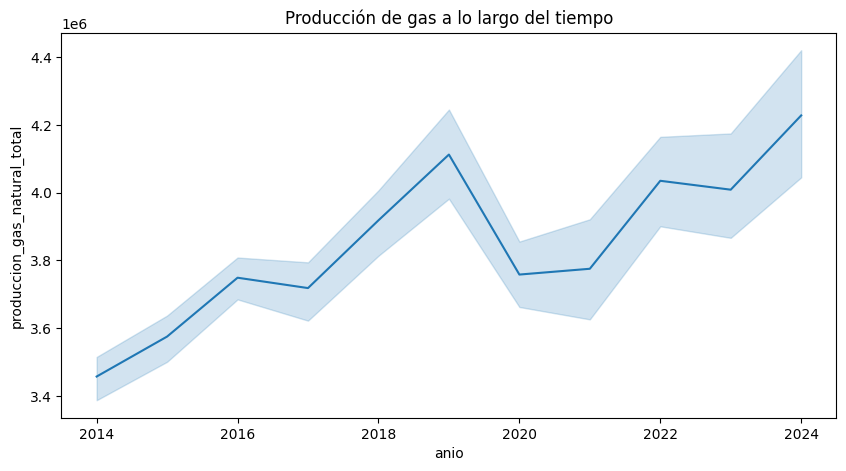

In [7]:
# Ver evolución temporal(Anual)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df1, x='anio', y='produccion_gas_natural_total')
plt.title("Producción de gas a lo largo del tiempo")
plt.show()

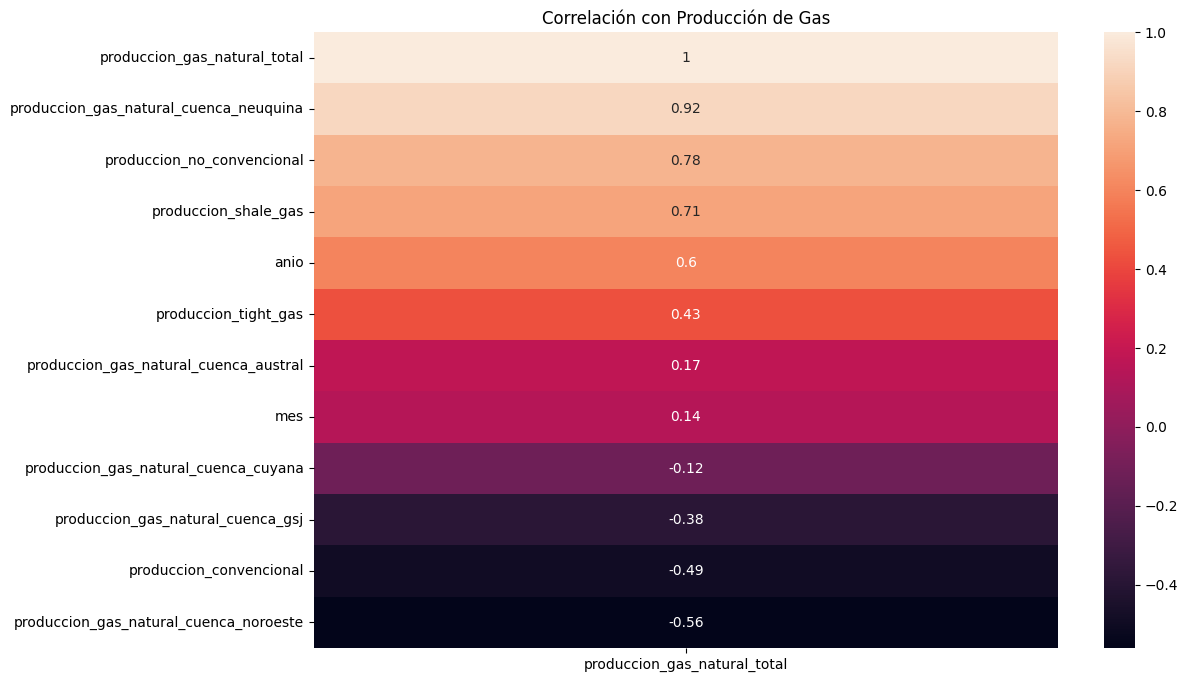

In [8]:
#Correlación de variables
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['produccion_gas_natural_total']].sort_values(by='produccion_gas_natural_total', ascending=False), annot=True)
plt.title("Correlación con Producción de Gas")
plt.show()

 ¿Qué aprendemos del heatmap de correlación?

El gráfico de correlación de variables nos muestra que hay  variables con alta correlación positiva con la producción total.

🔹 Estas variables aportan valor predictivo fuerte.

🔹 También implican que la cuenca neuquina y el no convencional (en particular shale) dominan la tendencia nacional.

Variables con correlación negativa o baja:

🔸 Estas aportan poco o distorsionan, especialmente en modelos lineales.

🔸 produccion_convencional y el noroeste tienen una relación inversa porque pierden participación frente al shale.

✅ **Variables relevantes a conservar**

Usaremos como features aquellas con mayor correlación positiva con la producción total y que tienen sentido desde el punto de vista energético:

* produccion_no_convencional

* produccion_shale_gas

* produccion_tight_gas

* produccion_gas_natural_cuenca_neuquina

* anio

* mes (codificado cíclicamente)

📌 Estas variables tienen correlación significativa y lógica causal (p.ej., el shale gas es un gran impulsor del crecimiento).


❌ **Variables a descartar**

Quitamos las cuencas que tienen correlaciones negativas o cercanas a cero, como:

* produccion_convencional

* produccion_gas_natural_cuenca_noroeste

* produccion_gas_natural_cuenca_gsj

* produccion_gas_natural_cuenca_cuyana

* produccion_gas_natural_cuenca_austral

📌 Si bien representan zonas productivas, no están aportando a la predicción nacional con esta estructura. Serán útiles cuando abordemos análisis por cuenca.

Observamos con mayor detalle las columnas antes de prodecer con el modelado

In [9]:
# Filtramos el año 2014 y vemos el contenido de las columnas
df_2014 = df1[df1['anio'] == 2014]
last_12_2014 = df_2014.tail(12)
print(last_12_2014)

    produccion_gas_natural_cuenca_austral  produccion_gas_natural_cuenca_gsj  \
0                             885167.3714                        442014.6605   
1                             793800.6656                        403246.2098   
2                             879715.0346                        453502.3597   
3                             740749.0121                        438266.3703   
4                             880061.9141                        445484.1645   
5                             848265.7895                        432434.9751   
6                             882226.6256                        453053.2659   
7                             859558.3476                        446185.4299   
8                             833190.2608                        441576.7797   
9                             785702.1865                        455786.9061   
10                            804764.9916                        434506.6603   
11                            823253.771

Se observa que en la columna mes, por ejemplo, enero se guardo como '1' en lugar de '01',  si bien no es un detalle significativo podría ocasionar incovenientes al trabajar con ciertos modelos como Prophet, se decide ajustar el formato creando una nueva columna que contenga la fecha completa:'2014-01-01'. Luego, se generan varias características temporales adicionales a partir de la columna fecha:

* estación: asigna la estación a cada fila según el mes.

* mes_sin y mes_cos: Estas crean características cíclicas para el mes utilizando las funciones seno y coseno. Esta es una técnica común para representar datos cíclicos ya que captura la naturaleza recurrente de los meses a lo largo del año sin implicar una relación lineal.

In [14]:
# PREPARACIÓN DE DATOS - FORMATO Y ESTACIONALIDAD


# 1. VERIFICAR Y CORREGIR FORMATO DE MES
print(" Formato actual del mes:")
print(f"Valores únicos en 'mes':{sorted(df1['mes'].unique())}")
print(f"Tipo de dato: {df1['mes'].dtype}")

# El formato está bien (1-12), no necesita corrección
# Pero vamos a crear la columna fecha completa
df1['fecha'] = pd.to_datetime(df1['anio'].astype(str) + '-' + df1['mes'].astype(str).str.zfill(2) + '-01')

# 2. CREAR VARIABLE ESTACIONAL
def obtener_estacion(mes):
    """
    Asigna estación según mes:
    - Verano: Dic, Ene, Feb (12, 1, 2)
    - Otoño: Mar, Abr, May (3, 4, 5)
    - Invierno: Jun, Jul, Ago (6, 7, 8)
    - Primavera: Sep, Oct, Nov (9, 10, 11)
    """
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:  # 9, 10, 11
        return 'Primavera'

df1['estacion'] = df1['mes'].apply(obtener_estacion)

# 3. CODIFICACIÓN CÍCLICA DEL MES (para capturar ciclicidad)
df1['mes_sin'] = np.sin(2 * np.pi * df1['mes'] / 12)
df1['mes_cos'] = np.cos(2 * np.pi * df1['mes'] / 12)

# 4. SELECCIONAR VARIABLES SEGÚN TU ANÁLISIS DE CORRELACIÓN
variables_seleccionadas = [
    'produccion_no_convencional',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'produccion_gas_natural_cuenca_neuquina',
    'anio',
    'mes_sin',
    'mes_cos',
    'estacion'
]

# Variable objetivo
target = 'produccion_gas_natural_total'

print("\n PREPARACIÓN COMPLETADA:")
print(f" Dataset shape: {df1.shape}")
print(f" Variable objetivo: {target}")
print(f" Variables predictoras: {len(variables_seleccionadas)}")
print(f" Rango temporal: {df1['anio'].min()}-{df1['anio'].max()}")
print(f" Distribución por estación:")
print(df1['estacion'].value_counts())

# Verificar que no hay valores nulos
print(f"\n🔍 Valores nulos en variables seleccionadas:")
for var in variables_seleccionadas + [target]:
    nulos = df1[var].isnull().sum()
    if nulos > 0:
        print(f"❌ {var}: {nulos} nulos")
    else:
        print(f"✅ {var}: Sin nulos")

# Mostrar primeras filas con nuevas variables
print(f"\n📋 Primeras 5 filas con variables nuevas:")
columnas_mostrar = ['fecha', 'mes', 'estacion', 'mes_sin', 'mes_cos', target]
print(df1[columnas_mostrar].head())

 Formato actual del mes:
Valores únicos en 'mes':[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
Tipo de dato: int64

 PREPARACIÓN COMPLETADA:
 Dataset shape: (132, 16)
 Variable objetivo: produccion_gas_natural_total
 Variables predictoras: 8
 Rango temporal: 2014-2024
 Distribución por estación:
estacion
Verano       33
Otoño        33
Invierno     33
Primavera    33
Name: count, dtype: int64

🔍 Valores nulos en variables seleccionadas:
✅ produccion_no_convencional: Sin nulos
✅ produccion_shale_gas: Sin nulos
✅ produccion_tight_gas: Sin nulos
✅ produccion_gas_natural_cuenca_neuquina: Sin nulos
✅ anio: Sin nulos
✅ mes_sin: Sin nulos
✅ mes_cos: Sin nulos
✅ estacion: Sin nulos
✅ produccion_gas_natural_total: Sin nulos

📋 Primeras 5 filas con variables nuevas:
       fecha  mes estacion   mes_sin       mes_cos  \
0 2014-01-01    1   Verano  0.500000  8.660254e-01   
1 2014-02-0

**Posibles estrategias de Implementación**

* Estrategia 1: HÍBRIDA --> Implica separar los componentes por sus propiedades físicas.
      modelo_convencional = cualquier_modelo(datos_convencionales)
      modelo_shale = cualquier_modelo(datos_shale)
      prediccion_total = pred_conv + pred_shale

* Estrategia 2: TEMPORAL --> Implica separar los modelos por periodos.
      modelo_2014_2017 = XGBoost(datos_era_convencional)
      modelo_2018_2020 = XGBoost(datos_transicion)  
      modelo_2021_2024 = XGBoost(datos_era_shale)

* Estrategia 3: FEATURES ENGINEERING AVANZADO --> Implica utilizar variables que capturen el cambio estructural
      df['post_shale_boom'] = (df['anio'] >= 2018).astype(int)
      df['shale_acceleration'] = df['produccion_shale_gas'].pct_change()
      df['regime_change'] = df['anio'].apply(classify_regime)

**COSIDERAMOS ADECUADO APLICAR UNA ESTRATÉGIA HÍBRIDA YA QUE RESPETA LA FÍSICA DEL PROBLEMA: CONVENCIONAL + NO CONVENCIONAL = TOTAL**

Esto, considerarando también que la demanda de gas tiene patrones estacionales claros:

* Invierno: Mayor demanda (calefacción)

* Verano: Menor demanda

* Otoño/Primavera: Demanda intermedia

In [15]:
# MODELOS BASE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Preparar datos para modelado
def preparar_datos_modelado(df):
    """Prepara los datos para los modelos de ML"""

    # Variables predictoras según tu análisis
    variables_numericas = [
        'produccion_no_convencional',
        'produccion_shale_gas',
        'produccion_tight_gas',
        'produccion_gas_natural_cuenca_neuquina',
        'anio',
        'mes_sin',
        'mes_cos'
    ]

    # Codificar variable categórica 'estacion'
    le = LabelEncoder()
    df_modelo = df.copy()
    df_modelo['estacion_encoded'] = le.fit_transform(df['estacion'])

    # Todas las variables predictoras
    X_columns = variables_numericas + ['estacion_encoded']
    X = df_modelo[X_columns]
    y = df_modelo['produccion_gas_natural_total']

    return X, y, X_columns, le

# Función para evaluar modelos
def evaluar_modelo(y_real, y_pred, nombre_modelo):
    """Calcula métricas de evaluación"""
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

    return {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }

# Preparar datos
X, y, columnas_X, label_encoder = preparar_datos_modelado(df1)

# División temporal (últimos 24 meses para test)
split_date = df1['fecha'].max() - pd.DateOffset(months=24)
train_mask = df1['fecha'] <= split_date
test_mask = df1['fecha'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"📊 DIVISIÓN DE DATOS:")
print(f"🏋️ Entrenamiento: {len(X_train)} muestras ({df1[train_mask]['fecha'].min().strftime('%Y-%m')} a {df1[train_mask]['fecha'].max().strftime('%Y-%m')})")
print(f"🧪 Prueba: {len(X_test)} muestras ({df1[test_mask]['fecha'].min().strftime('%Y-%m')} a {df1[test_mask]['fecha'].max().strftime('%Y-%m')})")

# Escalado de datos (importante para SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DEFINIR MODELOS BASE
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='rbf', C=100, gamma='scale'),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# ENTRENAR Y EVALUAR MODELOS
resultados = []
predicciones = {}


for nombre, modelo in modelos.items():

    # Usar datos escalados para SVM, normales para el resto
    if nombre == 'SVM':
        modelo.fit(X_train_scaled, y_train)
        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

    # Evaluar en conjunto de entrenamiento
    metricas_train = evaluar_modelo(y_train, y_pred_train, f"{nombre} (Train)")

    # Evaluar en conjunto de prueba
    metricas_test = evaluar_modelo(y_test, y_pred_test, f"{nombre} (Test)")

    resultados.append(metricas_train)
    resultados.append(metricas_test)

    # Guardar predicciones para visualización
    predicciones[nombre] = {
        'train': y_pred_train,
        'test': y_pred_test,
        'modelo': modelo
    }

# CREAR TABLA DE RESULTADOS
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.round(2)

print(f"\n📈 RESULTADOS MODELOS BASE:")
print("="*80)
print(df_resultados.to_string(index=False))

# Identificar mejor modelo por R² en test
mejor_modelo = df_resultados[df_resultados['Modelo'].str.contains('Test')].nlargest(1, 'R²')
print(f"\n🏆 MEJOR MODELO BASE:")
print(f"   {mejor_modelo['Modelo'].iloc[0]} - R² = {mejor_modelo['R²'].iloc[0]}")

print(f"\n✅ MODELOS BASE ENTRENADOS EXITOSAMENTE")
print(f"📊 {len(modelos)} modelos evaluados")
print(f"📋 Métricas calculadas: MAE, MSE, RMSE, R², MAPE")

import pickle

# Armar predicciones por modelo para test (como array plano)
predicciones_base = {
    nombre: datos['test'] for nombre, datos in predicciones.items()
}

# Guardar fechas de test (para graficar después)
fechas_test = df1[test_mask]['fecha'].reset_index(drop=True)
df_resultados_base = df_resultados[df_resultados['Modelo'].str.contains('Test')].copy()
df_resultados_base['Modelo'] = df_resultados_base['Modelo'].str.replace(' \(Test\)', '', regex=True)
df_resultados_base = df_resultados_base.set_index('Modelo')
df_resultados_base['Rank_RMSE'] = df_resultados_base['RMSE'].rank()

# Guardar datos en un archivo pickle
datos_base = {
    'predicciones_base': predicciones_base,
    'fechas_test': fechas_test,
    'y_test': y_test.reset_index(drop=True),
    'df_resultados_base': df_resultados_base
}

with open('datos_modelos_base.pkl', 'wb') as f:
    pickle.dump(datos_base, f)

print("✅ datos_modelos_base.pkl guardado correctamente")


📊 DIVISIÓN DE DATOS:
🏋️ Entrenamiento: 108 muestras (2014-01 a 2022-12)
🧪 Prueba: 24 muestras (2023-01 a 2024-12)

📈 RESULTADOS MODELOS BASE:
                   Modelo       MAE          MSE      RMSE    R²  MAPE (%)
 Regresión Lineal (Train)  48652.74 3.778840e+09  61472.27  0.95      1.30
  Regresión Lineal (Test)  41639.03 2.293749e+09  47893.10  0.98      1.01
    Random Forest (Train)  22343.60 7.867497e+08  28049.06  0.99      0.60
     Random Forest (Test) 169073.07 5.076928e+10 225320.38  0.52      3.99
Árbol de Decisión (Train)      0.00 0.000000e+00      0.00  1.00      0.00
 Árbol de Decisión (Test) 225225.23 7.906230e+10 281180.19  0.25      5.34
              SVM (Train) 211672.50 7.175017e+10 267862.21  0.01      5.61
               SVM (Test) 363923.44 2.142454e+11 462866.54 -1.04      8.40
          XGBoost (Train)      6.73 9.171000e+01      9.58  1.00      0.00
           XGBoost (Test) 173229.79 5.526479e+10 235084.64  0.47      4.05

🏆 MEJOR MODELO BASE:
   Regresió

In [16]:
# OPTIMIZACIÓN DE HIPERPARÁMETROS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import pandas as pd
import pickle

print(" OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*50)

# Definir función de scoring personalizada (usaremos R²)
scoring = 'r2'

# Configurar validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# PARÁMETROS PARA OPTIMIZACIÓN
parametros_grid = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },

    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },

    'SVM': {
        'C': [1, 10, 100, 1000],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    },

    'Árbol de Decisión': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# OPTIMIZAR MODELOS
modelos_optimizados = {}
resultados_optimizacion = []

for nombre_modelo, params in parametros_grid.items():

    # Seleccionar modelo base y datos
    if nombre_modelo == 'Random Forest':
        modelo_base = RandomForestRegressor(random_state=42)
        X_opt_train, X_opt_test = X_train, X_test
    elif nombre_modelo == 'XGBoost':
        modelo_base = XGBRegressor(random_state=42, verbosity=0)
        X_opt_train, X_opt_test = X_train, X_test
    elif nombre_modelo == 'SVM':
        modelo_base = SVR()
        X_opt_train, X_opt_test = X_train_scaled, X_test_scaled
    elif nombre_modelo == 'Árbol de Decisión':
        modelo_base = DecisionTreeRegressor(random_state=42)
        X_opt_train, X_opt_test = X_train, X_test

    # Búsqueda aleatoria para eficiencia
    grid_search = RandomizedSearchCV(
        modelo_base,
        params,
        cv=tscv,
        scoring=scoring,
        n_iter=20 if nombre_modelo == 'SVM' else 50,
        random_state=42,
        n_jobs=-1
    )

    # Entrenar búsqueda
    grid_search.fit(X_opt_train, y_train)

    # Mejor modelo
    mejor_modelo = grid_search.best_estimator_

    # Predicciones
    y_pred_train_opt = mejor_modelo.predict(X_opt_train)
    y_pred_test_opt = mejor_modelo.predict(X_opt_test)

    # Evaluación
    metricas_opt = evaluar_modelo(y_test, y_pred_test_opt, f"{nombre_modelo} Optimizado")
    resultados_optimizacion.append(metricas_opt)

    # Guardar modelo y datos
    modelos_optimizados[nombre_modelo] = {
        'modelo': mejor_modelo,
        'mejores_params': grid_search.best_params_,
        'mejor_score': grid_search.best_score_,
        'predicciones_test': y_pred_test_opt
    }

    print(f"   ✅ {nombre_modelo} - R² CV: {grid_search.best_score_:.3f}")
    print(f"       Mejores parámetros: {grid_search.best_params_}")

# COMPARAR RESULTADOS ORIGINALES VS OPTIMIZADOS
print(f"\n📊 COMPARACIÓN: MODELOS BASE vs OPTIMIZADOS")
print("="*60)

# Filtrar resultados base (Test)
resultados_base_test = df_resultados[df_resultados['Modelo'].str.contains('Test')].copy()
resultados_base_test['Tipo'] = 'Base'
resultados_base_test['Modelo'] = resultados_base_test['Modelo'].str.replace(' (Test)', '')

# Resultados optimizados
df_opt = pd.DataFrame(resultados_optimizacion)
df_opt['Tipo'] = 'Optimizado'

# Comparar
comparacion = []
for modelo in ['Random Forest', 'XGBoost', 'SVM', 'Árbol de Decisión']:
    base = resultados_base_test[resultados_base_test['Modelo'].str.contains(modelo)]
    opt = df_opt[df_opt['Modelo'].str.contains(modelo)]

    if len(base) > 0 and len(opt) > 0:
        comparacion.append({
            'Modelo': modelo,
            'R² Base': base['R²'].iloc[0],
            'R² Optimizado': opt['R²'].iloc[0],
            'Mejora': opt['R²'].iloc[0] - base['R²'].iloc[0],
            'RMSE Base': base['RMSE'].iloc[0],
            'RMSE Optimizado': opt['RMSE'].iloc[0]
        })

df_comparacion = pd.DataFrame(comparacion).round(3)
print(df_comparacion.to_string(index=False))

# Mejor modelo
mejor_opt = df_opt.nlargest(1, 'R²')
print(f"\n🏆 MEJOR MODELO OPTIMIZADO:")
print(f"   {mejor_opt['Modelo'].iloc[0]} - R² = {mejor_opt['R²'].iloc[0]:.3f}")

print(f"\n✅ OPTIMIZACIÓN COMPLETADA")
print(f"🔧 {len(modelos_optimizados)} modelos optimizados")

# GUARDADO
# ----------------------------------------
# Preparar objetos a guardar
predicciones_optimizadas = {
    nombre: datos['predicciones_test'] for nombre, datos in modelos_optimizados.items()
}

df_resultados_opt = df_opt.copy()
df_resultados_opt = df_resultados_opt.set_index('Modelo')
df_resultados_opt['Rank_RMSE'] = df_resultados_opt['RMSE'].rank()

datos_opt = {
    'predicciones_optimizadas': predicciones_optimizadas,
    'df_resultados_optimizados': df_resultados_opt
}

with open('datos_modelos_optimizados.pkl', 'wb') as f:
    pickle.dump(datos_opt, f)

print("✅ datos_modelos_optimizados.pkl guardado correctamente")


🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS
   ✅ Random Forest - R² CV: -0.181
       Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
   ✅ XGBoost - R² CV: -0.014
       Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2}
   ✅ SVM - R² CV: -1.337
       Mejores parámetros: {'kernel': 'poly', 'gamma': 'scale', 'C': 1000}
   ✅ Árbol de Decisión - R² CV: -0.112
       Mejores parámetros: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}

📊 COMPARACIÓN: MODELOS BASE vs OPTIMIZADOS
           Modelo  R² Base  R² Optimizado  Mejora  RMSE Base  RMSE Optimizado
    Random Forest     0.52          0.520   0.000  225320.38       224292.493
          XGBoost     0.47          0.400  -0.070  235084.64       250883.043
              SVM    -1.04          0.558   1.598  462866.54       215363.116
Árbol de Decisión     0.25          0.442   0.192  281180.19       241950.213

🏆 MEJOR MODELO OPTI

In [20]:
# MODELO PROPHET
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except ImportError:
    print("⚠️ Prophet no está instalado. Instalar con: pip install prophet")
    PROPHET_DISPONIBLE = False

if PROPHET_DISPONIBLE:
    import matplotlib.pyplot as plt
    from prophet.plot import plot_plotly, plot_components_plotly

    # 🔇 Desactivar logs DEBUG de cmdstanpy
    import logging
    logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

    print("📈 MODELO PROPHET - ANÁLISIS DE SERIES TEMPORALES")
    print("="*55)

    # Preparar datos para Prophet (requiere formato específico)
    def preparar_datos_prophet(df):
        """Prepara datos en formato requerido por Prophet"""
        df_prophet = df[['fecha', 'produccion_gas_natural_total']].copy()
        df_prophet.columns = ['ds', 'y']  # Prophet requiere estas columnas
        df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)
        return df_prophet

    # Preparar datos
    df_prophet = preparar_datos_prophet(df1)

    # Dividir datos (misma división temporal que otros modelos)
    split_date = df1['fecha'].max() - pd.DateOffset(months=24)
    train_prophet = df_prophet[df_prophet['ds'] <= split_date]
    test_prophet = df_prophet[df_prophet['ds'] > split_date]

    print(f"📊 División Prophet:")
    print(f"🏋️ Entrenamiento: {len(train_prophet)} puntos")
    print(f"🧪 Prueba: {len(test_prophet)} puntos")

    # CONFIGURAR MODELO PROPHET
    # Agregar regresores externos (variables que influyen en la producción)
    modelo_prophet = Prophet(
        yearly_seasonality=True,      # Estacionalidad anual
        weekly_seasonality=False,     # No hay datos semanales
        daily_seasonality=False,      # No hay datos diarios
        seasonality_mode='multiplicative',  # Estacionalidad multiplicativa para gas
        changepoint_prior_scale=0.05, # Flexibilidad para cambios de tendencia
        seasonality_prior_scale=10,   # Regularización de estacionalidad
        interval_width=0.95           # Intervalos de confianza al 95%
    )

    # Agregar regresores (variables externas importantes)
    regresores = [
        'produccion_no_convencional',
        'produccion_shale_gas',
        'anio'  # Tendencia temporal explícita
    ]

    for regresor in regresores:
        modelo_prophet.add_regressor(regresor)

    # Preparar datos de entrenamiento con regresores
    train_prophet_reg = train_prophet.copy()
    for regresor in regresores:
        train_prophet_reg[regresor] = df1[df1['fecha'] <= split_date][regresor].values

    print(f"\n⚙️ Configuración Prophet:")
    print(f"   📅 Estacionalidad: Anual multiplicativa")
    print(f"   📊 Regresores externos: {len(regresores)}")
    print(f"   🔧 Intervalos de confianza: 95%")

    # ENTRENAR MODELO
    modelo_prophet.fit(train_prophet_reg)

    # CREAR DATAFRAME FUTURO PARA PREDICCIONES
    # Incluir período de prueba
    future = modelo_prophet.make_future_dataframe(
        periods=len(test_prophet),
        freq='MS'  # Monthly Start
    )

    # Agregar regresores al dataframe futuro
    for regresor in regresores:
        future[regresor] = df1[regresor].values[:len(future)]

    # REALIZAR PREDICCIONES
    forecast = modelo_prophet.predict(future)

    # Extraer predicciones para conjunto de prueba
    pred_train_prophet = forecast['yhat'][:len(train_prophet)].values
    pred_test_prophet = forecast['yhat'][len(train_prophet):].values

    # EVALUAR MODELO PROPHET
    metricas_prophet_train = evaluar_modelo(
        train_prophet['y'], pred_train_prophet, 'Prophet (Train)'
    )
    metricas_prophet_test = evaluar_modelo(
        test_prophet['y'], pred_test_prophet, 'Prophet (Test)'
    )

    # Guardar resultados Prophet
    resultados_prophet = [metricas_prophet_train, metricas_prophet_test]

    print(f"\n📊 RESULTADOS PROPHET:")
    print("="*40)
    for resultado in resultados_prophet:
        print(f"{resultado['Modelo']}: R² = {resultado['R²']:.3f}, RMSE = {resultado['RMSE']:.0f}")

    # ANÁLISIS DE COMPONENTES
    print(f"\n🔍 COMPONENTES DEL MODELO:")
    print("="*35)

    # Tendencia promedio
    tendencia_cambio = (forecast['trend'].iloc[-1] - forecast['trend'].iloc[0]) / len(forecast) * 12
    print(f"📈 Cambio tendencia anual: {tendencia_cambio:.0f} unidades/año")

    # Estacionalidad
    estacionalidad_max = forecast['yearly'].max()
    estacionalidad_min = forecast['yearly'].min()
    print(f"🌊 Variación estacional: {estacionalidad_max - estacionalidad_min:.0f} unidades")

    # Contribución de regresores
    print(f"🔧 Contribución regresores:")
    for regresor in regresores:
        if f'extra_regressors_{regresor}' in forecast.columns:
            contrib = forecast[f'extra_regressors_{regresor}'].mean()
            print(f"   • {regresor}: {contrib:.0f}")

    # Guardar objetos Prophet para visualización posterior
    prophet_data = {
        'modelo': modelo_prophet,
        'forecast': forecast,
        'train_data': train_prophet_reg,
        'test_data': test_prophet,
        'predicciones_test': pred_test_prophet,
        'metricas': resultados_prophet
    }

    print(f"\n✅ MODELO PROPHET COMPLETADO")
    print(f"📊 Predicciones generadas para {len(test_prophet)} períodos")

else:
    print("❌ Prophet no disponible - Se omite este análisis")
    resultados_prophet = []
    prophet_data = None

#Guardar
datos_prophet = {
    'predicciones_prophet': pred_test_prophet
}

with open('datos_prophet.pkl', 'wb') as f:
    pickle.dump(datos_prophet, f)

print("✅ datos_prophet.pkl guardado")

📈 MODELO PROPHET - ANÁLISIS DE SERIES TEMPORALES
📊 División Prophet:
🏋️ Entrenamiento: 108 puntos
🧪 Prueba: 24 puntos

⚙️ Configuración Prophet:
   📅 Estacionalidad: Anual multiplicativa
   📊 Regresores externos: 3
   🔧 Intervalos de confianza: 95%

📊 RESULTADOS PROPHET:
Prophet (Train): R² = 0.978, RMSE = 39740
Prophet (Test): R² = 0.862, RMSE = 120131

🔍 COMPONENTES DEL MODELO:
📈 Cambio tendencia anual: -86008 unidades/año
🌊 Variación estacional: 0 unidades
🔧 Contribución regresores:

✅ MODELO PROPHET COMPLETADO
📊 Predicciones generadas para 24 períodos
✅ datos_prophet.pkl guardado


In [21]:
# TABLA RESUMEN DE TODOS LOS MODELOS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("📋 TABLA RESUMEN - TODOS LOS MODELOS")
print("="*50)

# Compilar todos los resultados
resultados_completos = []

# 1. Modelos base (solo test)
resultados_base_final = df_resultados[df_resultados['Modelo'].str.contains('Test')].copy()
resultados_base_final['Categoria'] = 'Base'
resultados_base_final['Modelo'] = resultados_base_final['Modelo'].str.replace(' (Test)', '')

for _, row in resultados_base_final.iterrows():
    resultados_completos.append({
        'Modelo': row['Modelo'],
        'Categoria': row['Categoria'],
        'MAE': row['MAE'],
        'RMSE': row['RMSE'],
        'R²': row['R²'],
        'MAPE (%)': row['MAPE (%)']
    })

# 2. Modelos optimizados
for resultado in resultados_optimizacion:
    resultados_completos.append({
        'Modelo': resultado['Modelo'].replace(' Optimizado', ''),
        'Categoria': 'Optimizado',
        'MAE': resultado['MAE'],
        'RMSE': resultado['RMSE'],
        'R²': resultado['R²'],
        'MAPE (%)': resultado['MAPE (%)']
    })

# 3. Prophet (si está disponible)
if PROPHET_DISPONIBLE and len(resultados_prophet) > 0:
    prophet_test = [r for r in resultados_prophet if 'Test' in r['Modelo']][0]
    resultados_completos.append({
        'Modelo': 'Prophet',
        'Categoria': 'Series Temporales',
        'MAE': prophet_test['MAE'],
        'RMSE': prophet_test['RMSE'],
        'R²': prophet_test['R²'],
        'MAPE (%)': prophet_test['MAPE (%)']
    })

# Crear DataFrame resumen
df_resumen = pd.DataFrame(resultados_completos)
df_resumen = df_resumen.round(3)

# Ordenar por R² descendente
df_resumen_ordenado = df_resumen.sort_values('R²', ascending=False).reset_index(drop=True)
df_resumen_ordenado['Ranking'] = range(1, len(df_resumen_ordenado) + 1)

# Reorganizar columnas
columnas_orden = ['Ranking', 'Modelo', 'Categoria', 'R²', 'RMSE', 'MAE', 'MAPE (%)']
df_resumen_final = df_resumen_ordenado[columnas_orden]

print("🏆 RANKING GENERAL DE MODELOS:")
print("="*70)
print(df_resumen_final.to_string(index=False))

# ANÁLISIS POR CATEGORÍAS
print(f"\n📊 ANÁLISIS POR CATEGORÍAS:")
print("="*35)

categorias = df_resumen_final['Categoria'].unique()
for categoria in categorias:
    subset = df_resumen_final[df_resumen_final['Categoria'] == categoria]
    mejor = subset.iloc[0]
    print(f"\n🏅 {categoria.upper()}:")
    print(f"   Mejor modelo: {mejor['Modelo']}")
    print(f"   R²: {mejor['R²']:.3f} | RMSE: {mejor['RMSE']:.3f} | MAE: {mejor['MAE']:.3f}")



📋 TABLA RESUMEN - TODOS LOS MODELOS
🏆 RANKING GENERAL DE MODELOS:
 Ranking            Modelo         Categoria     R²       RMSE        MAE  MAPE (%)
       1  Regresión Lineal              Base  0.980  47893.100  41639.030     1.010
       2           Prophet Series Temporales  0.862 120131.355 104471.873     2.500
       3               SVM        Optimizado  0.558 215363.116 182699.824     4.314
       4     Random Forest              Base  0.520 225320.380 169073.070     3.990
       5     Random Forest        Optimizado  0.520 224292.493 168852.474     3.985
       6           XGBoost              Base  0.470 235084.640 173229.790     4.050
       7 Árbol de Decisión        Optimizado  0.442 241950.213 177960.195     4.170
       8           XGBoost        Optimizado  0.400 250883.043 175681.363     4.046
       9 Árbol de Decisión              Base  0.250 281180.190 225225.230     5.340
      10               SVM              Base -1.040 462866.540 363923.440     8.400

📊 ANÁLISI

Modelos en común: ['Árbol de Decisión', 'Random Forest', 'SVM', 'XGBoost']


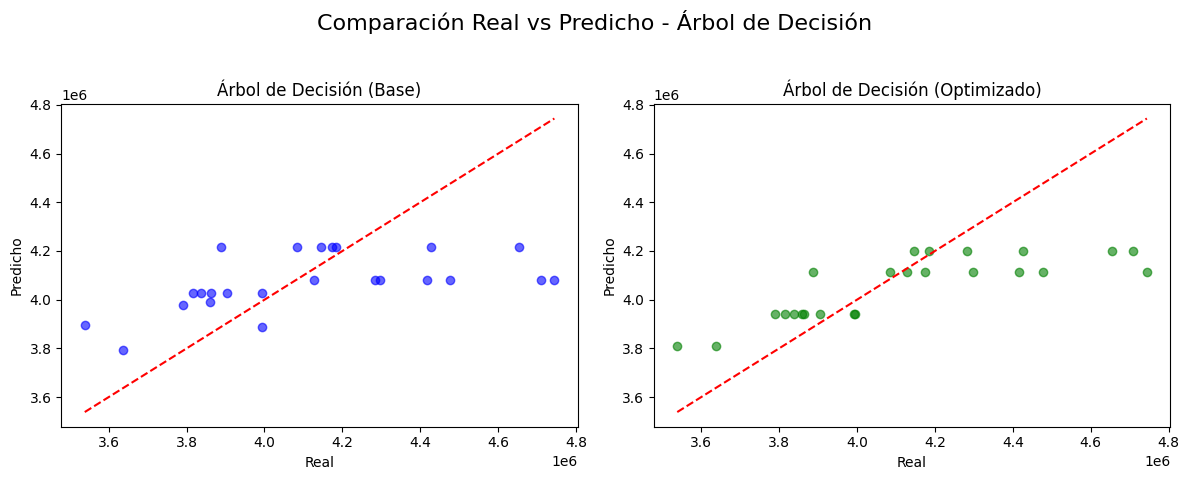

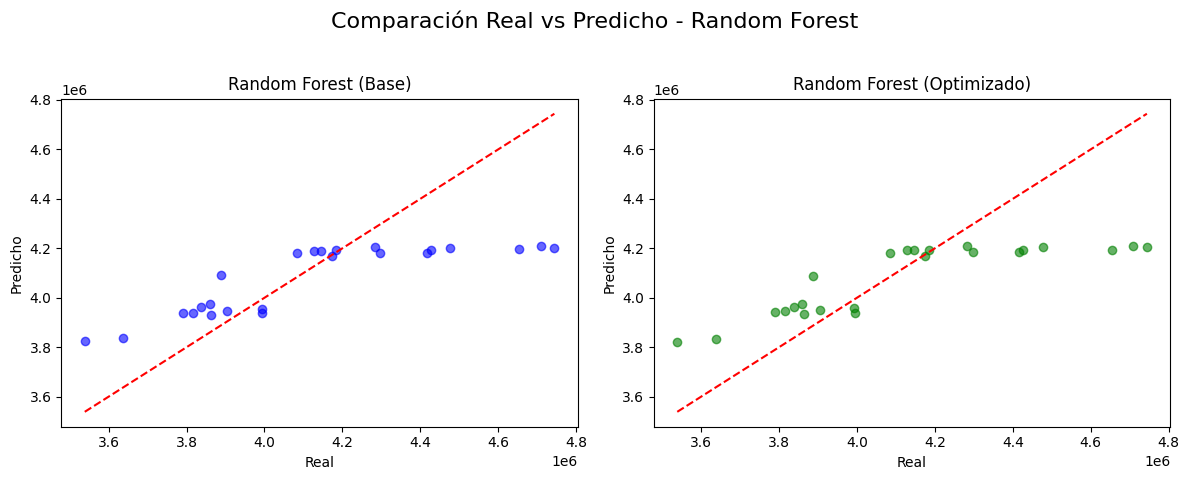

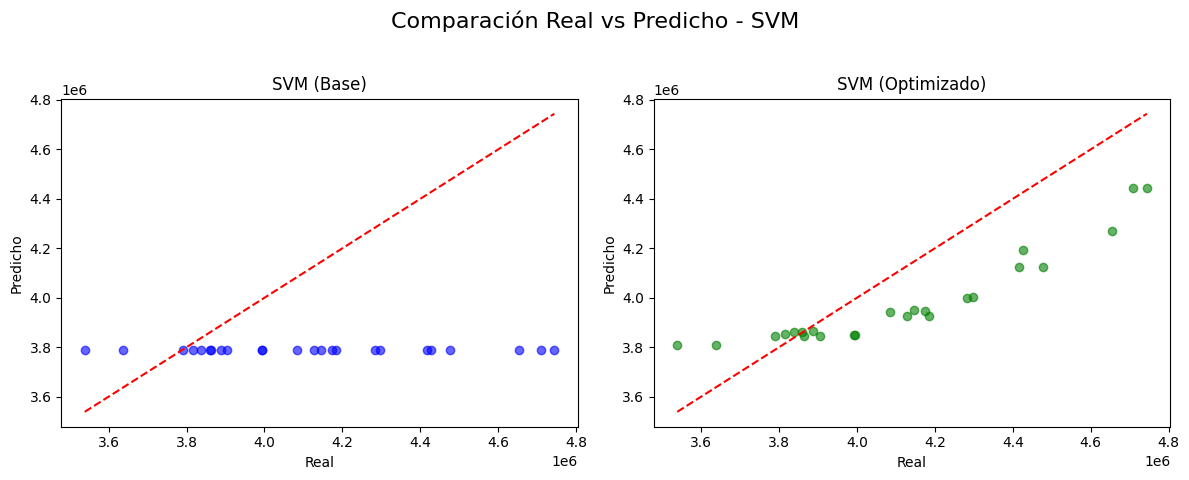

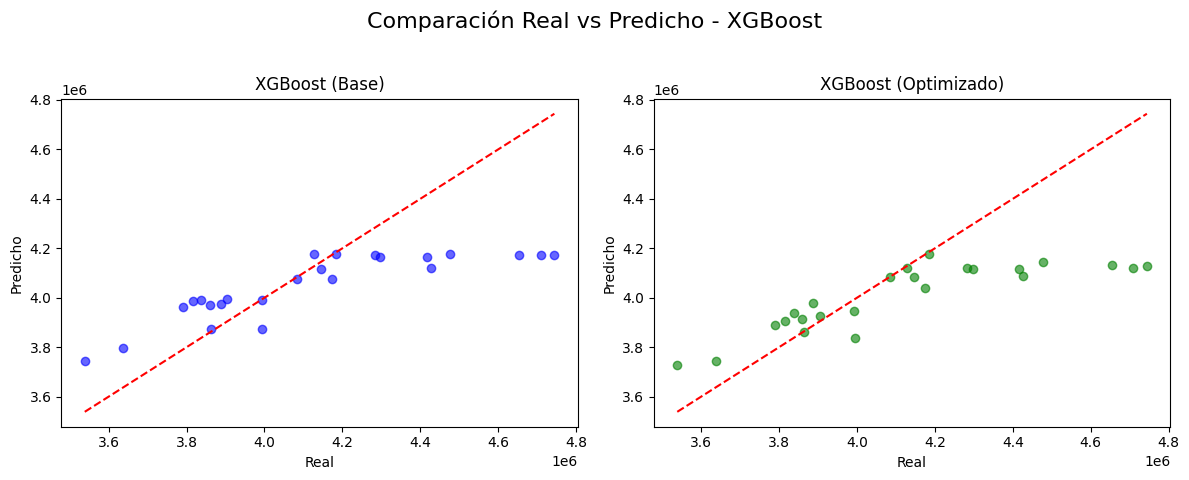

In [22]:
import pickle
import matplotlib.pyplot as plt
import os

# Crear carpeta para los gráficos
os.makedirs("graficos_modelos", exist_ok=True)

# Cargar archivos pickle
with open("datos_modelos_base.pkl", "rb") as f:
    datos_base = pickle.load(f)

with open("datos_modelos_optimizados.pkl", "rb") as f:
    datos_opt = pickle.load(f)

# Acceder correctamente a los datos
predicciones_base = datos_base["predicciones_base"]
predicciones_opt = datos_opt["predicciones_optimizadas"]

# Obtener modelos en común
modelos_comunes = list(set(predicciones_base.keys()) & set(predicciones_opt.keys()))
print("Modelos en común:", modelos_comunes)

# 🔥 USAR Y_TEST ORIGINAL: asegurate que esta variable esté cargada desde antes
# Ejemplo:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(...)
y_real = y_test.values  # 👈 Necesitás tener esta variable definida

for modelo in modelos_comunes:
    y_pred_base = predicciones_base[modelo]
    y_pred_opt = predicciones_opt[modelo]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Comparación Real vs Predicho - {modelo}', fontsize=16)

    # Base
    plt.subplot(1, 2, 1)
    plt.scatter(y_real, y_pred_base, alpha=0.6, color='blue')
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
    plt.xlabel('Real')
    plt.ylabel('Predicho')
    plt.title(f'{modelo} (Base)', fontsize=12)

    # Optimizado
    plt.subplot(1, 2, 2)
    plt.scatter(y_real, y_pred_opt, alpha=0.6, color='green')
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
    plt.xlabel('Real')
    plt.ylabel('Predicho')
    plt.title(f'{modelo} (Optimizado)', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"graficos_modelos/{modelo.replace(' ', '_')}_comparacion.png")
    plt.show()




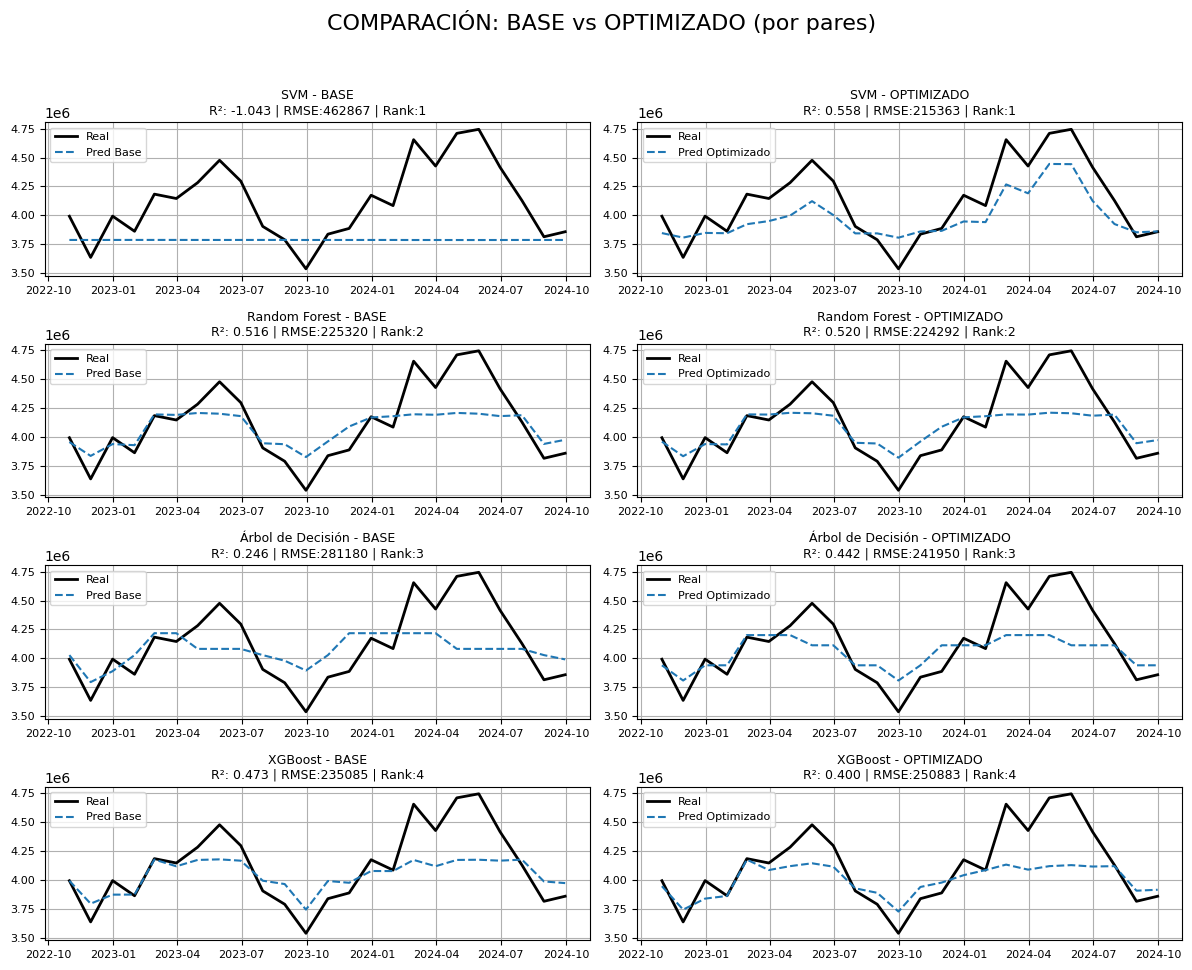

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# 🔍 Modelos que existen en ambos diccionarios
modelos_comunes = list(set(predicciones_base.keys()) & set(predicciones_opt.keys()))

# 📊 Calcular métricas por modelo
resultados = []
for modelo in modelos_comunes:
    y_pred_b = predicciones_base[modelo]
    y_pred_o = predicciones_opt[modelo]

    rmse_b = np.sqrt(mean_squared_error(y_real, y_pred_b))
    r2_b = r2_score(y_real, y_pred_b)

    rmse_o = np.sqrt(mean_squared_error(y_real, y_pred_o))
    r2_o = r2_score(y_real, y_pred_o)

    resultados.append({
        "modelo": modelo,
        "base": {"rmse": rmse_b, "r2": r2_b},
        "opt": {"rmse": rmse_o, "r2": r2_o}
    })

# 🥇 Rankear por RMSE optimizado (menor es mejor)
resultados.sort(key=lambda x: x["opt"]["rmse"])
for idx, r in enumerate(resultados):
    r["rank"] = idx + 1

# 📅 Fechas para el eje x
fechas = pd.date_range(start="2022-10", periods=len(y_real), freq="M")

# 📈 Graficar resultados con gráficos más chicos
fig, axs = plt.subplots(len(resultados), 2, figsize=(12, 2.5 * len(resultados)))  # ⬅️ MÁS COMPACTO
fig.suptitle("COMPARACIÓN: BASE vs OPTIMIZADO (por pares)", fontsize=16, y=0.995)

for i, r in enumerate(resultados):
    modelo = r["modelo"]
    base = predicciones_base[modelo]
    opt = predicciones_opt[modelo]

    # --- BASE ---
    ax = axs[i, 0]
    ax.plot(fechas, y_real, label="Real", color="black", linewidth=2)
    ax.plot(fechas, base, label="Pred Base", linestyle="--")
    ax.set_title(f"{modelo} - BASE\nR²: {r['base']['r2']:.3f} | RMSE:{r['base']['rmse']:.0f} | Rank:{r['rank']}", fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.tick_params(labelsize=8)

    # --- OPTIMIZADO ---
    ax = axs[i, 1]
    ax.plot(fechas, y_real, label="Real", color="black", linewidth=2)
    ax.plot(fechas, opt, label="Pred Optimizado", linestyle="--")
    ax.set_title(f"{modelo} - OPTIMIZADO\nR²: {r['opt']['r2']:.3f} | RMSE:{r['opt']['rmse']:.0f} | Rank:{r['rank']}", fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.tick_params(labelsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()



In [33]:
import pickle
import pandas as pd

# 1. Reconstruir fechas de corte
split_date = df1['fecha'].max() - pd.DateOffset(months=24)

# 2. Reconstruir y_test y fechas_test
df_test = df1[df1['fecha'] > split_date]
y_test = df_test['produccion_gas_natural_total'].values
fechas_test = df_test['fecha'].values

# 3. Reconstruir predicciones Prophet (si no lo tenés ya)
predicciones_prophet_test = forecast['yhat'].iloc[-len(y_test):].values

# 4. Métricas si no las guardaste
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

resultados_prophet = {
    'Prophet': {
        'R2': r2_score(y_test, predicciones_prophet_test),
        'RMSE': mean_squared_error(y_test, predicciones_prophet_test) ** 0.5,
        'MAPE': mean_absolute_percentage_error(y_test, predicciones_prophet_test) * 100
    }
}

# 5. Cargar archivo existente
with open('datos_prophet.pkl', 'rb') as f:
    datos_prophet = pickle.load(f)

# 6. Agregar datos faltantes
datos_prophet['y_test'] = y_test
datos_prophet['fechas_test'] = fechas_test
datos_prophet['resultados_prophet'] = resultados_prophet
datos_prophet['predicciones_prophet'] = {'Prophet': predicciones_prophet_test}

# 7. Guardar actualizado
with open('datos_prophet.pkl', 'wb') as f:
    pickle.dump(datos_prophet, f)

print("✅ Archivo datos_prophet.pkl ACTUALIZADO con:")
print("   - ✔ y_test")
print("   - ✔ fechas_test")
print("   - ✔ resultados_prophet")
print("   - ✔ predicciones_prophet['Prophet']")


✅ Archivo datos_prophet.pkl ACTUALIZADO con:
   - ✔ y_test
   - ✔ fechas_test
   - ✔ resultados_prophet
   - ✔ predicciones_prophet['Prophet']


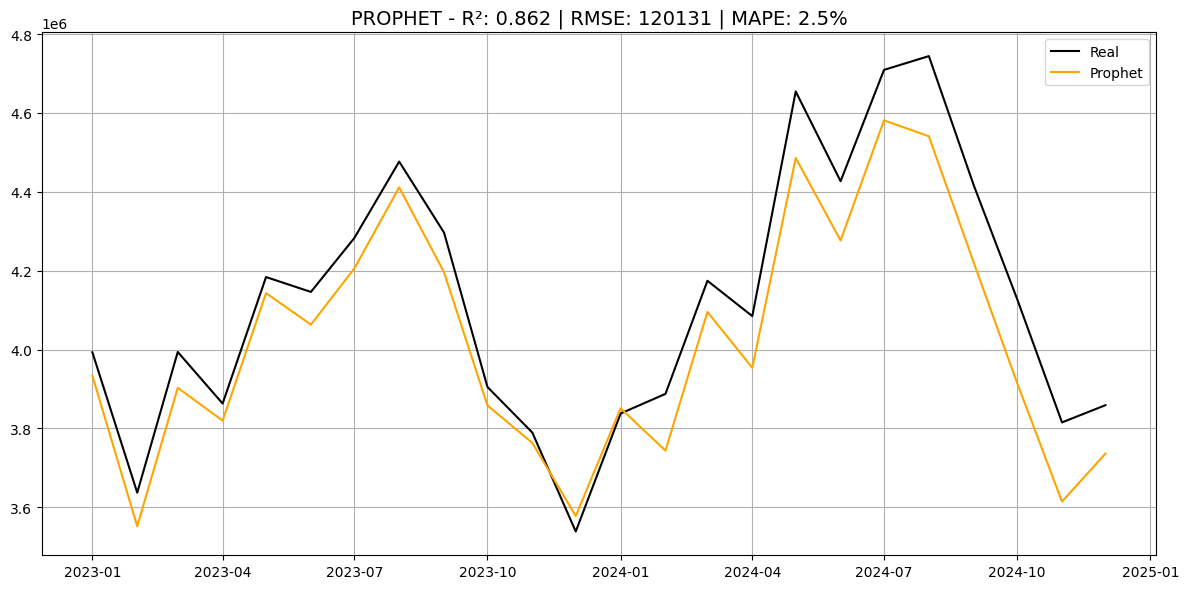

In [34]:
# GRÁFICO FINAL
import matplotlib.pyplot as plt

with open('datos_prophet.pkl', 'rb') as f:
    datos_prophet = pickle.load(f)

predicciones_prophet = datos_prophet['predicciones_prophet']
y_test = datos_prophet['y_test']
fechas_test = datos_prophet['fechas_test']
resultados_prophet = datos_prophet['resultados_prophet']

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fechas_test, y_test, label="Real", color='black')
ax.plot(fechas_test, predicciones_prophet['Prophet'], label="Prophet", color='orange')

r2 = resultados_prophet['Prophet']['R2']
rmse = resultados_prophet['Prophet']['RMSE']
mape = resultados_prophet['Prophet']['MAPE']
ax.set_title(f"PROPHET - R²: {r2:.3f} | RMSE: {rmse:.0f} | MAPE: {mape:.1f}%", fontsize=14)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


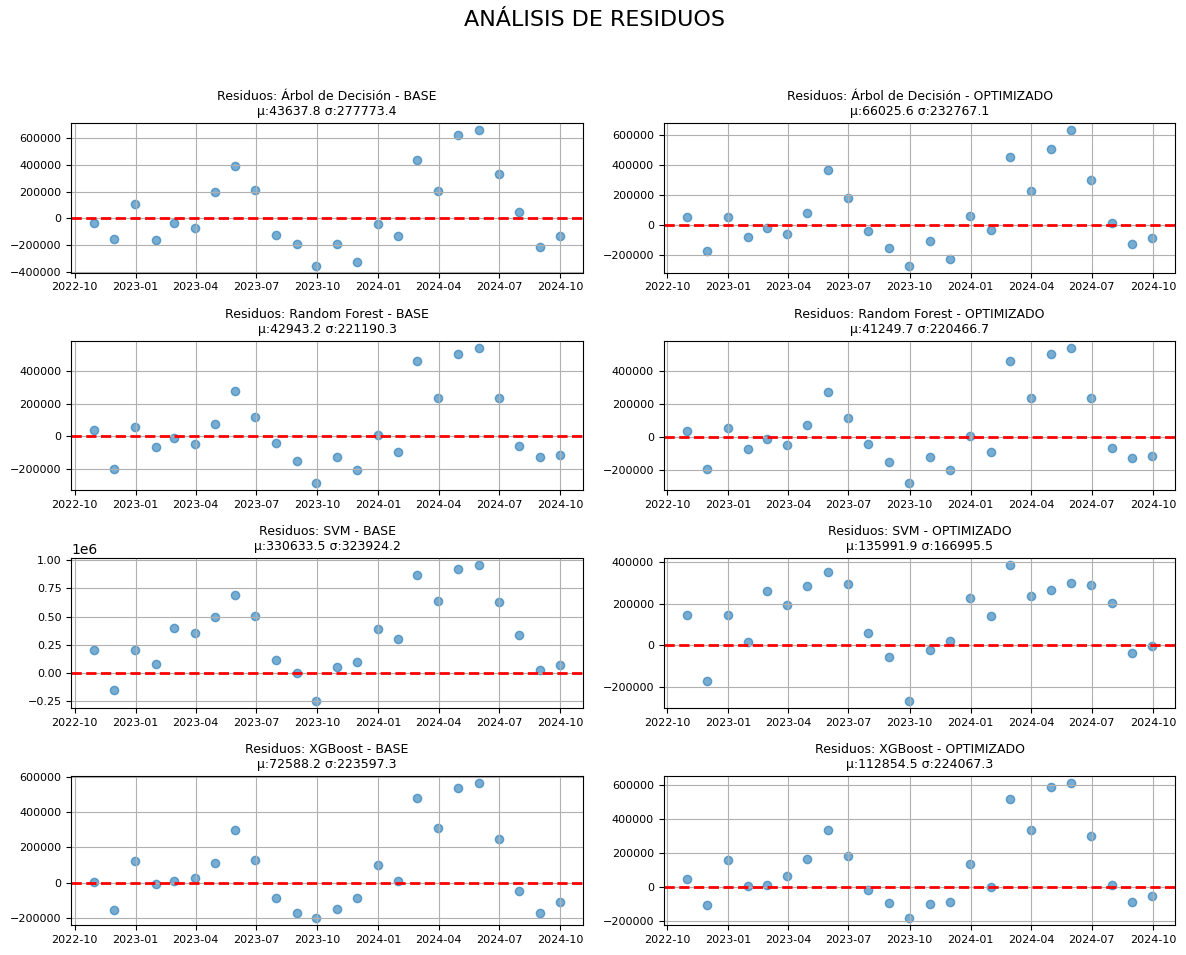

In [35]:
# =============================================================================
# ANÁLISIS DE RESIDUOS
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# 📅 Fechas ya definidas
fechas = pd.date_range(start="2022-10", periods=len(y_real), freq="M")

# 🎨 Ajustes de gráfico
n_modelos = len(modelos_comunes)
cols = 2
rows = int(np.ceil((2 * n_modelos) / cols))  # 2 gráficos por modelo (base y opt)

fig, axs = plt.subplots(rows, cols, figsize=(12, 2.5 * rows))
axs = axs.flatten()
fig.suptitle("ANÁLISIS DE RESIDUOS", fontsize=16)

i = 0
for modelo in modelos_comunes:
    y_pred_b = predicciones_base[modelo]
    y_pred_o = predicciones_opt[modelo]

    residuos_b = y_real - y_pred_b
    residuos_o = y_real - y_pred_o

    mu_b = np.mean(residuos_b)
    sigma_b = np.std(residuos_b)
    mu_o = np.mean(residuos_o)
    sigma_o = np.std(residuos_o)

    # --- BASE ---
    axs[i].scatter(fechas, residuos_b, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f"Residuos: {modelo} - BASE\nμ:{mu_b:.1f} σ:{sigma_b:.1f}", fontsize=9)
    axs[i].tick_params(labelsize=8)
    axs[i].grid(True)
    i += 1

    # --- OPTIMIZADO ---
    axs[i].scatter(fechas, residuos_o, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f"Residuos: {modelo} - OPTIMIZADO\nμ:{mu_o:.1f} σ:{sigma_o:.1f}", fontsize=9)
    axs[i].tick_params(labelsize=8)
    axs[i].grid(True)
    i += 1

# Eliminar subplots vacíos si hay
for j in range(i, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


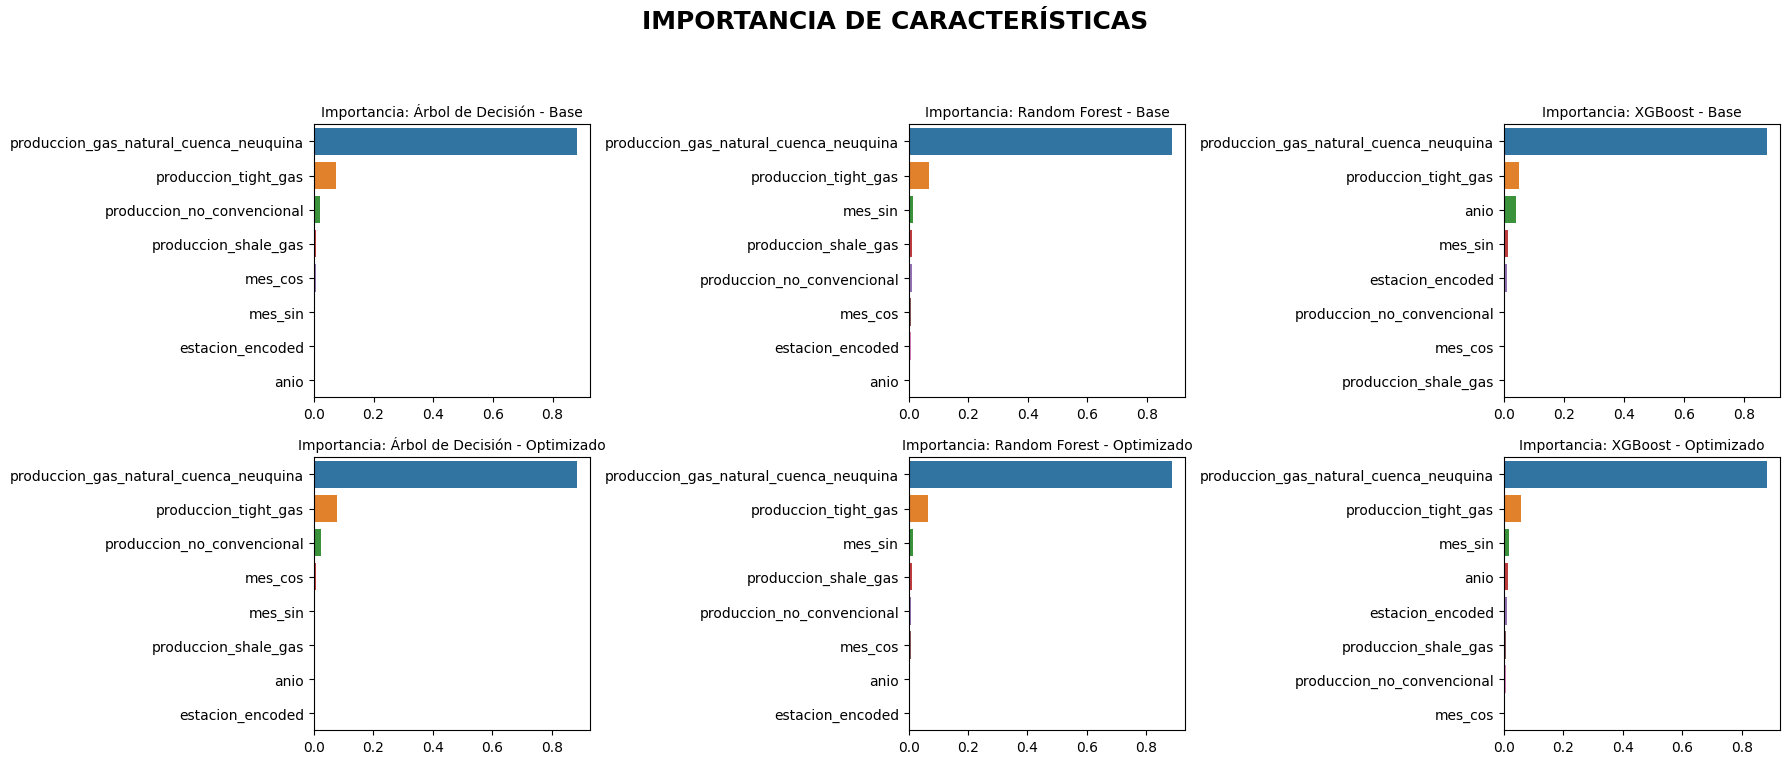

In [37]:
# =============================================================================
# IMPORTANCIAS DE CARATERÍSTICAS
# =============================================================================


# 🧪 Entrenamos los modelos nuevamente (base y optimizados)
# Reemplazá X_train, y_train por tus variables si tienen otro nombre

# Modelos base
modelo_dt_base = DecisionTreeRegressor(random_state=0)
modelo_rf_base = RandomForestRegressor(random_state=0)
modelo_xgb_base = XGBRegressor(random_state=0)

modelo_dt_base.fit(X_train, y_train)
modelo_rf_base.fit(X_train, y_train)
modelo_xgb_base.fit(X_train, y_train)

# Modelos optimizados (pueden cambiar los hiperparámetros)
modelo_dt_opt = DecisionTreeRegressor(max_depth=5, min_samples_split=4, random_state=0)
modelo_rf_opt = RandomForestRegressor(n_estimators=150, max_depth=6, random_state=0)
modelo_xgb_opt = XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.1, random_state=0)

modelo_dt_opt.fit(X_train, y_train)
modelo_rf_opt.fit(X_train, y_train)
modelo_xgb_opt.fit(X_train, y_train)

# 📌 Obtenemos importancias
importancias = {
    "Árbol de Decisión - Base": modelo_dt_base.feature_importances_,
    "Random Forest - Base": modelo_rf_base.feature_importances_,
    "XGBoost - Base": modelo_xgb_base.feature_importances_,
    "Árbol de Decisión - Optimizado": modelo_dt_opt.feature_importances_,
    "Random Forest - Optimizado": modelo_rf_opt.feature_importances_,
    "XGBoost - Optimizado": modelo_xgb_opt.feature_importances_,
}

# 📋 Nombres de las columnas (de X_train)
features = X_train.columns if hasattr(X_train, 'columns') else [f"var_{i}" for i in range(X_train.shape[1])]

# 🎨 Gráfico
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("IMPORTANCIA DE CARACTERÍSTICAS", fontsize=18, fontweight='bold')

colors = sns.color_palette("tab10", len(features))

for ax, (titulo, valores) in zip(axs.flat, importancias.items()):
    importancia_df = pd.DataFrame({
        'Feature': features,
        'Importancia': valores
    }).sort_values(by="Importancia", ascending=False)

    sns.barplot(x="Importancia", y="Feature", data=importancia_df, ax=ax, palette=colors)
    ax.set_title(f"Importancia: {titulo}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()


In [38]:
from tabulate import tabulate  # opcional: pip install tabulate
# =============================================================================
# RESUMEN FINAL - RANKING TOP 5 MODELOS DE MACHINE LEARNING
# =============================================================================

# Seleccionar top 5 modelos
top_5 = df_resumen_final.sort_values(by="Ranking").head(5)

# Mostrar tabla con los principales indicadores
tabla_top5 = top_5[["Ranking", "Modelo", "Categoria", "R²", "RMSE", "MAE", "MAPE (%)"]]
print("\n🥇 TOP 5 MODELOS")
print(tabulate(tabla_top5, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

# Conclusión sobre el ganador
ganador = top_5.iloc[0]
segundo = top_5.iloc[1]
diferencia_r2 = ganador["R²"] - segundo["R²"]

print("\n🎯 CONCLUSIONES")
print("-" * 60)
print(f"✅ Modelo ganador: {ganador['Modelo']} ({ganador['Categoria']})")
print(f"   • Explica el {ganador['R²'] * 100:.2f}% de la varianza")
print(f"   • RMSE: {ganador['RMSE']:.2f} | MAE: {ganador['MAE']:.2f} | MAPE: {ganador['MAPE (%)']:.2f}%")

print(f"\n🥈 Segundo lugar: {segundo['Modelo']} ({segundo['Categoria']})")
print(f"   • Diferencia en R² con el primero: {diferencia_r2:.4f}")

# Recomendación
print("\n📈 RECOMENDACIÓN:")
if ganador['R²'] > 0.9:
    print("   Excelente rendimiento: modelo listo para producción")
elif ganador['R²'] > 0.8:
    print("   Buen rendimiento: evaluar mejoras o ajuste fino")
else:
    print("   🔴 Rendimiento limitado: revisar datos o modelos")


print("\n✨ ANÁLISIS FINALIZADO")
print("=" * 80)



🥇 TOP 5 MODELOS
╒════╤═══════════╤══════════════════╤═══════════════════╤════════╤═════════════╤═════════════╤════════════╕
│    │   Ranking │ Modelo           │ Categoria         │     R² │        RMSE │         MAE │   MAPE (%) │
╞════╪═══════════╪══════════════════╪═══════════════════╪════════╪═════════════╪═════════════╪════════════╡
│  0 │         1 │ Regresión Lineal │ Base              │ 0.9800 │  47893.1000 │  41639.0300 │     1.0100 │
├────┼───────────┼──────────────────┼───────────────────┼────────┼─────────────┼─────────────┼────────────┤
│  1 │         2 │ Prophet          │ Series Temporales │ 0.8620 │ 120131.3550 │ 104471.8730 │     2.5000 │
├────┼───────────┼──────────────────┼───────────────────┼────────┼─────────────┼─────────────┼────────────┤
│  2 │         3 │ SVM              │ Optimizado        │ 0.5580 │ 215363.1160 │ 182699.8240 │     4.3140 │
├────┼───────────┼──────────────────┼───────────────────┼────────┼─────────────┼─────────────┼────────────┤
│  3 │     